## Capstone Project 1: Data Wrangling

**Google link**: https://docs.google.com/document/d/1EBtoL05Ir64pk1aDLzz0nKp1YVikfVR0fGMQv5lTsqg/edit?usp=sharing

Steps:

1. Create a Google Doc (1-2 pages) describing the data wrangling steps you took to clean the dataset. Include answers to these questions in your submission:

2. What kind of cleaning steps did you perform?
 - Drop unnecessary columns
 - Apply datetime format
 - Calculate 24 month customer lifetime revenue by using order table based on item order data set
 - Get first order revenue per customer based on item order data set
 - Create dataset on customer_id level: contains all first order infomation + first order reveue +  24 month lifetime revenue

3. How did you deal with missing values, if any?
 - del rows since only 2 missing values for each column

4. Were there outliers, and how did you handle them?
keep outliers since those are extreme values - some customers submitted large orders

5. Submit a link to the document.

6. Discuss it with your mentor at the next call.

7. Revise and resubmit if needed.

8. Convert the final document to a .pdf and add it to your GitHub repository for this project. This document will eventually become part of your milestone report.

In [2]:
# from google.colab import files
import io

#uploaded = files.upload()
# df.to_csv('df.csv')
# files.download('df.csv')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.plotting.register_matplotlib_converters()
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


import seaborn as sns
sns.set(rc={'figure.figsize':(16.7,6.27)})


from plotly.offline import init_notebook_mode, iplot # plotly offline mode
init_notebook_mode(connected=True) 
import plotly.graph_objs as go # plotly graphical object

import os
# print(os.listdir("../input"))

import warnings            
warnings.filterwarnings("ignore") 

from pandas import datetime
import datetime

# Basic  EDA
from sklearn.externals.six import StringIO
import statsmodels.api as sm
from scipy import stats
from sklearn import preprocessing

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



## load helper functions

In [2]:
# find the unique values in each column
def unique_counts(customer):
    for i in customer.columns:
        count=customer[i].nunique()
        print(i, ':', count)
        

#print missing value table
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values ', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns  

In [3]:
customer=pd.read_csv('https://drive.google.com/uc?export=download&id=1wv4GrazmaBO4wd6FuNay7pillVkUzzs7')
# customer=pd.read_csv('/Users/lylay/Desktop/spring board/bb_customer')
order=pd.read_csv('/Users/lylay/Desktop/spring board/bb_order.csv')

In [4]:
print(customer.dtypes)
print()
print(customer.head())
print()
print('rows and cols of cutomer data:', customer.shape)
print()
print(order.head())
print('rows and cols of cutomer data:', order.shape)

customer_id                                 int64
registered_date                            object
email_address                              object
postal_code                                object
state_or_province                          object
fo_order_channel                           object
fo_origin                                  object
fo_f_item                                  object
fo_f_category                              object
fo_f_product                               object
fo_ga_channel                              object
fo_qm_channel                              object
fo_qm_publisher                            object
fo_qm_device                               object
fo_custom_flag                            float64
fo_company_name_flag                      float64
fo_discount_flag                          float64
fo_ffr_flag                               float64
fo_quote_flag                             float64
fo_upload_flag                            float64


In [5]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218367 entries, 0 to 218366
Data columns (total 35 columns):
customer_id                               218367 non-null int64
registered_date                           218367 non-null object
email_address                             218367 non-null object
postal_code                               119662 non-null object
state_or_province                         119662 non-null object
fo_order_channel                          218367 non-null object
fo_origin                                 193456 non-null object
fo_f_item                                 218367 non-null object
fo_f_category                             218367 non-null object
fo_f_product                              218367 non-null object
fo_ga_channel                             207109 non-null object
fo_qm_channel                             210536 non-null object
fo_qm_publisher                           142730 non-null object
fo_qm_device                              141

In [6]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048574 entries, 0 to 1048573
Data columns (total 23 columns):
item_id              1048574 non-null object
order_id             1048574 non-null object
ga_order_id          1048574 non-null int64
customer_id          1048574 non-null int64
order_date           1048574 non-null object
page_title           674067 non-null object
product              1048574 non-null object
item_origin          944820 non-null object
revenue              1048574 non-null float64
facility_name        1048574 non-null object
quantity             1048574 non-null int64
p1                   972589 non-null object
p2                   55523 non-null object
p3                   34818 non-null object
p4                   908786 non-null object
p5                   108 non-null object
p6                   169414 non-null object
p7                   10752 non-null object
shipping_method      999421 non-null object
shipping_zip_code    983942 non-null object
addres

## Step 1: calculate first order revenue and 24 month lifetime revenue per customer
Use order(on item level) to calculate first order revenue per customer
And 24month customer lifetime revenue per customer by summing up all order reveue for each customer within 730 days since the first order date

In [7]:
# drop cols
cols_to_drop=['item_id', 'Unnamed: 22','Unnamed: 21','p5','p7','p3','p2','p6']
order.drop(cols_to_drop, axis=1, inplace=True)

# apply datetime format
order['order_date'] =  pd.to_datetime(order['order_date'], infer_datetime_format=True)
order2=order.groupby(['customer_id'])['order_date'].min().reset_index(name='min_order_date')
order=pd.merge(order, order2, on='customer_id')
order['cut_date_24m']= order.min_order_date + datetime.timedelta(days=730)

# Calculate 24 month lifetime revenue and create column: revenue_24m
df1=order.groupby('customer_id').apply(lambda x: x[(x['order_date'] >= x['min_order_date']) & (x['order_date'] <= x['cut_date_24m'])]['revenue'].sum())
df1=df1.reset_index(name='revenue_24m')

In [8]:
order[['min_order_date']].max()

min_order_date   2019-06-26
dtype: datetime64[ns]

In [9]:
order[['order_date']].max()

order_date   2019-06-26
dtype: datetime64[ns]

In [10]:
order.loc[order['order_date']=='2019-06-26']

,order_id,ga_order_id,customer_id,order_date,page_title,product,item_origin,revenue,facility_name,quantity,p1,p4,shipping_method,shipping_zip_code,address_flag,min_order_date,cut_date_24m
76,1381853-NEW,1381853,1522012,2019-06-26,NaN,Stock Image,Online-Desktop,12.0,Van Nuys,1,NaN,NaN,NaN,NaN,Unknown,2019-06-26,2021-06-25


## calculate first order revenue

In [11]:
#Create first order info table for each customer based on order data sets
first_order_info= order.loc[order.order_date==order.min_order_date][['customer_id','ga_order_id','page_title','product','item_origin','revenue','facility_name','quantity',
                                                                     'p1','p4', 'shipping_method','address_flag', 'min_order_date']]

# rename column 'revenue' into 'first_order_revenue_item' since the df contains customer info of first order only
first_order_info.rename(columns={'revenue':'first_order_revenue_item'}, inplace=True)

# do a quick check
print(first_order_info.shape)

(443790, 13)


From df1 we know total customer count = 301599 but we have total first order count= 443790 which means some customer order more than one item on their first order. So we need to calculate first order_revenue. This is also aligned with our dataset info.

In [12]:
# do a quick check: first order item per customer
first_order_info[['customer_id','ga_order_id']].groupby('customer_id').count()

,ga_order_id
customer_id,
7172,1
7258,1
7260,1
7354,2
7374,1
7408,2
7450,1
7519,1
7546,1


In [13]:
first_revenue= first_order_info.groupby('customer_id')['first_order_revenue_item'].sum().reset_index(name='first_order_total_revenue')

## Step 2: add 24month ltv and first order revenue to the customer dataframe

In [20]:
customer2=customer.merge(first_revenue, on='customer_id').merge(df1, on='customer_id')
customer2.shape

(118651, 37)

In [21]:
customer2.head()

,customer_id,registered_date,email_address,postal_code,state_or_province,fo_order_channel,fo_origin,fo_f_item,fo_f_category,fo_f_product,fo_ga_channel,fo_qm_channel,fo_qm_publisher,fo_qm_device,fo_custom_flag,fo_company_name_flag,fo_discount_flag,fo_ffr_flag,fo_quote_flag,fo_upload_flag,fedex_fo_address_flag,first_order_id,first_order_source,first_h_item_id,customer_first_order_own_shipping_flag,count_of_lifetime_orders,count_of_lifetime_items,sum_lifetime_net_sales,first_order_revenue,address_flag,Printing_facility,qty_first_order,Unnamed: 32,Unnamed: 33,Unnamed: 34,first_order_total_revenue,revenue_24m
0,3822657,1/1/17,gmail.com,92883,CA,Online,NaN,Car Magnets,Magnets,Marketing Materials,NaN,Non-Brand SEM,Google,computer,0.0,0.0,0.0,0.0,0.0,1.0,Residential,3000093,1,4434741,n,1,1,34.42,34.42,Residential,Van Nuys,2.0,NaN,NaN,NaN,34.42,34.42
1,3822663,1/1/17,ca.rr.com,90038,CA,Online,Online-Desktop,Large Format Posters,Posters,Signage and Display,Non-Branded Paid Search,Non-Brand SEM,Google,computer,0.0,0.0,0.0,0.0,0.0,1.0,Business,3000101,1,4434749,n,1,1,26.18,26.18,Business,Van Nuys,1.0,NaN,NaN,NaN,26.18,26.18
2,3822667,1/1/17,gmail.com,NaN,NaN,Online,Online-Desktop,Stickers,Stickers,Stickers and Labels,Non-Branded Paid Search,Non-Brand SEM,Google,computer,0.0,0.0,0.0,0.0,0.0,1.0,Residential,3000108,1,4434762,n,1,1,34.14,34.14,Residential,Van Nuys,100.0,NaN,NaN,NaN,34.14,34.14
3,3822673,1/1/17,paradies-na.com,75261,TX,Online,Online-Desktop,Rack Cards,Rack Cards,Marketing Materials,Direct,Direct,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,Business,3000115,1,4434770,n,2,2,144.85,47.96,Business,Arlington,100.0,NaN,NaN,NaN,47.96,144.85
4,3822677,1/1/17,aol.com,NaN,NaN,Online,Online-Desktop,Labels,Labels,Stickers and Labels,Direct,Direct,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,Residential,3000118,1,4434775,n,1,1,48.87,48.87,Residential,Arlington,75.0,NaN,NaN,NaN,48.87,48.87


In [22]:
customers=customer2.merge(first_order_info[['customer_id','min_order_date']], on='customer_id')
print(customers.shape)
print(customers.min_order_date.max())

(171805, 38)
2018-01-08 00:00:00


In [23]:
customers.registered_date.max()

'9/9/17'

In [24]:
customers.registered_date.min()

'1/1/17'

In [25]:
customers.head()

,customer_id,registered_date,email_address,postal_code,state_or_province,fo_order_channel,fo_origin,fo_f_item,fo_f_category,fo_f_product,fo_ga_channel,fo_qm_channel,fo_qm_publisher,fo_qm_device,fo_custom_flag,fo_company_name_flag,fo_discount_flag,fo_ffr_flag,fo_quote_flag,fo_upload_flag,fedex_fo_address_flag,first_order_id,first_order_source,first_h_item_id,customer_first_order_own_shipping_flag,count_of_lifetime_orders,count_of_lifetime_items,sum_lifetime_net_sales,first_order_revenue,address_flag,Printing_facility,qty_first_order,Unnamed: 32,Unnamed: 33,Unnamed: 34,first_order_total_revenue,revenue_24m,min_order_date
0,3822657,1/1/17,gmail.com,92883,CA,Online,NaN,Car Magnets,Magnets,Marketing Materials,NaN,Non-Brand SEM,Google,computer,0.0,0.0,0.0,0.0,0.0,1.0,Residential,3000093,1,4434741,n,1,1,34.42,34.42,Residential,Van Nuys,2.0,NaN,NaN,NaN,34.42,34.42,2017-01-01
1,3822663,1/1/17,ca.rr.com,90038,CA,Online,Online-Desktop,Large Format Posters,Posters,Signage and Display,Non-Branded Paid Search,Non-Brand SEM,Google,computer,0.0,0.0,0.0,0.0,0.0,1.0,Business,3000101,1,4434749,n,1,1,26.18,26.18,Business,Van Nuys,1.0,NaN,NaN,NaN,26.18,26.18,2017-01-01
2,3822667,1/1/17,gmail.com,NaN,NaN,Online,Online-Desktop,Stickers,Stickers,Stickers and Labels,Non-Branded Paid Search,Non-Brand SEM,Google,computer,0.0,0.0,0.0,0.0,0.0,1.0,Residential,3000108,1,4434762,n,1,1,34.14,34.14,Residential,Van Nuys,100.0,NaN,NaN,NaN,34.14,34.14,2017-01-01
3,3822673,1/1/17,paradies-na.com,75261,TX,Online,Online-Desktop,Rack Cards,Rack Cards,Marketing Materials,Direct,Direct,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,Business,3000115,1,4434770,n,2,2,144.85,47.96,Business,Arlington,100.0,NaN,NaN,NaN,47.96,144.85,2017-01-01
4,3822677,1/1/17,aol.com,NaN,NaN,Online,Online-Desktop,Labels,Labels,Stickers and Labels,Direct,Direct,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,Residential,3000118,1,4434775,n,1,1,48.87,48.87,Residential,Arlington,75.0,NaN,NaN,NaN,48.87,48.87,2017-01-01


## Step 3: check data type, missing value 

In [26]:
# call helper function to check missing values
missing_values_table(customers)

Your selected dataframe has 38 columns.
There are 13 columns that have missing values.


,Missing Values,% of Total Values
Unnamed: 32,171805,100.0
Unnamed: 33,171805,100.0
Unnamed: 34,171805,100.0
postal_code,82451,48.0
state_or_province,82451,48.0
fo_qm_device,60785,35.4
fo_qm_publisher,60673,35.3
fo_origin,18253,10.6
fo_ga_channel,9191,5.3
fo_qm_channel,6653,3.9


In [27]:
# call helper functions to check unique values in each column
unique_counts(customers)  

# - for fo_f_category  either drop it, hard code and inpute several labels or try other model: DNN, import datatwig (library)

customer_id : 118651
registered_date : 310
email_address : 37531
postal_code : 18187
state_or_province : 56
fo_order_channel : 3
fo_origin : 3
fo_f_item : 126
fo_f_category : 62
fo_f_product : 14
fo_ga_channel : 11
fo_qm_channel : 11
fo_qm_publisher : 2
fo_qm_device : 3
fo_custom_flag : 2
fo_company_name_flag : 2
fo_discount_flag : 2
fo_ffr_flag : 2
fo_quote_flag : 2
fo_upload_flag : 2
fedex_fo_address_flag : 5
first_order_id : 118651
first_order_source : 1
first_h_item_id : 118651
customer_first_order_own_shipping_flag : 2
count_of_lifetime_orders : 81
count_of_lifetime_items : 133
sum_lifetime_net_sales : 41052
first_order_revenue : 25373
address_flag : 5
Printing_facility : 5
qty_first_order : 166
Unnamed: 32 : 0
Unnamed: 33 : 0
Unnamed: 34 : 0
first_order_total_revenue : 32334
revenue_24m : 40611
min_order_date : 332


In [28]:
customers.columns

Index(['customer_id', 'registered_date', 'email_address', 'postal_code',
       'state_or_province', 'fo_order_channel', 'fo_origin', 'fo_f_item',
       'fo_f_category', 'fo_f_product', 'fo_ga_channel', 'fo_qm_channel',
       'fo_qm_publisher', 'fo_qm_device', 'fo_custom_flag',
       'fo_company_name_flag', 'fo_discount_flag', 'fo_ffr_flag',
       'fo_quote_flag', 'fo_upload_flag', 'fedex_fo_address_flag',
       'first_order_id', 'first_order_source', 'first_h_item_id',
       'customer_first_order_own_shipping_flag', 'count_of_lifetime_orders',
       'count_of_lifetime_items', 'sum_lifetime_net_sales',
       'first_order_revenue', 'address_flag', 'Printing_facility',
       'qty_first_order', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34',
       'first_order_total_revenue', 'revenue_24m', 'min_order_date'],
      dtype='object')

In [29]:
# get unique value for each column
for col in list(customers[['fo_order_channel', 'fo_origin', 'fo_ga_channel', 'fo_qm_channel',
       'fo_qm_publisher', 'fo_qm_device', 'fo_custom_flag',
       'fo_company_name_flag', 'fo_discount_flag', 'fo_ffr_flag',
       'fo_quote_flag', 'fo_upload_flag', 'fedex_fo_address_flag',
       'first_order_source', 'customer_first_order_own_shipping_flag', 'address_flag', 'Printing_facility']]):
    print(col)
    print(customers[col].unique())

fo_order_channel
['Online' 'FFR' 'Quotes']
fo_origin
[nan 'Online-Desktop' 'Online-Tablet' 'Online-Mobile']
fo_ga_channel
[nan 'Non-Branded Paid Search' 'Direct' 'PLA' 'Organic Search' 'Referral'
 'Branded Paid Search' 'Social' 'Email' '(Other)' 'Paid Search' 'Display']
fo_qm_channel
['Non-Brand SEM' 'Direct' 'Shopping' 'Organic Search' 'Referral'
 'Brand SEM' nan 'Social' 'Email' 'Display' '(Other)' 'Paid Search']
fo_qm_publisher
['Google' nan 'Bing']
fo_qm_device
['computer' nan 'mobile' 'tablet']
fo_custom_flag
[0. 1.]
fo_company_name_flag
[0. 1.]
fo_discount_flag
[0. 1.]
fo_ffr_flag
[0. 1.]
fo_quote_flag
[0. 1.]
fo_upload_flag
[1. 0.]
fedex_fo_address_flag
['Residential' 'Business' 'Unknown' 'Pickup' 'Mixed']
first_order_source
[1]
customer_first_order_own_shipping_flag
['n' 'y']
address_flag
['Residential' 'Business' 'Unknown' 'Pickup' 'Mixed']
Printing_facility
['Van Nuys' 'Arlington' 'Saddle Brook' 'Cleveland' 'Magnets4Media' nan]


#### Drop unused columns
1. 'Unnamed: 32','Unnamed: 33','Unnamed: 34','first_h_item_id','first_order_id','min_order_date','registered_date', 'email_address' - no needed
2. 'fo_custom_flag' - tells us whether this columns is a first order or not. We're using the firs order revenue to predict 24 months revenue.So we know all first revenue in this dataframe is the first order. Thus we don't need this column
3. 'first_order_source' - only 1 value
4. 'count_of_lifetime_orders', 'count_of_lifetime_items' - we're not trying to predict those variables and we are not able to figure them out with only the first order info
5. 'fo_ga_channel' - same as 'fo_qm_channel'. We keep 'fo_qm_channel'
6. 'fo_ffr_flag','fo_quote_flag' - 'fo_order_channel' contains those information
7. 'postal_code','registered_date', 'email_address' - very likely we don't need them so far.


In [30]:
# drop cols
cols_to_drop=['Unnamed: 32','Unnamed: 33','Unnamed: 34','fo_custom_flag','first_order_source','first_h_item_id','first_order_id','min_order_date',
                'fo_ga_channel','fo_ffr_flag','fo_quote_flag','postal_code','registered_date', 'email_address','count_of_lifetime_orders',
        'count_of_lifetime_items']
customers.drop(cols_to_drop, axis=1, inplace=True)
#check dataframe
customers.head()

,customer_id,state_or_province,fo_order_channel,fo_origin,fo_f_item,fo_f_category,fo_f_product,fo_qm_channel,fo_qm_publisher,fo_qm_device,fo_company_name_flag,fo_discount_flag,fo_upload_flag,fedex_fo_address_flag,customer_first_order_own_shipping_flag,sum_lifetime_net_sales,first_order_revenue,address_flag,Printing_facility,qty_first_order,first_order_total_revenue,revenue_24m
0,3822657,CA,Online,NaN,Car Magnets,Magnets,Marketing Materials,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Residential,n,34.42,34.42,Residential,Van Nuys,2.0,34.42,34.42
1,3822663,CA,Online,Online-Desktop,Large Format Posters,Posters,Signage and Display,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Business,n,26.18,26.18,Business,Van Nuys,1.0,26.18,26.18
2,3822667,NaN,Online,Online-Desktop,Stickers,Stickers,Stickers and Labels,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Residential,n,34.14,34.14,Residential,Van Nuys,100.0,34.14,34.14
3,3822673,TX,Online,Online-Desktop,Rack Cards,Rack Cards,Marketing Materials,Direct,NaN,NaN,1.0,0.0,1.0,Business,n,144.85,47.96,Business,Arlington,100.0,47.96,144.85
4,3822677,NaN,Online,Online-Desktop,Labels,Labels,Stickers and Labels,Direct,NaN,NaN,0.0,0.0,1.0,Residential,n,48.87,48.87,Residential,Arlington,75.0,48.87,48.87


#### check df again

In [31]:
print(customers.shape)

(171805, 22)


In [32]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171805 entries, 0 to 171804
Data columns (total 22 columns):
customer_id                               171805 non-null int64
state_or_province                         89354 non-null object
fo_order_channel                          171805 non-null object
fo_origin                                 153552 non-null object
fo_f_item                                 171805 non-null object
fo_f_category                             171805 non-null object
fo_f_product                              171805 non-null object
fo_qm_channel                             165152 non-null object
fo_qm_publisher                           111132 non-null object
fo_qm_device                              111020 non-null object
fo_company_name_flag                      171805 non-null float64
fo_discount_flag                          171805 non-null float64
fo_upload_flag                            171805 non-null float64
fedex_fo_address_flag                     1

In [33]:
unique_counts(customers)

customer_id : 118651
state_or_province : 56
fo_order_channel : 3
fo_origin : 3
fo_f_item : 126
fo_f_category : 62
fo_f_product : 14
fo_qm_channel : 11
fo_qm_publisher : 2
fo_qm_device : 3
fo_company_name_flag : 2
fo_discount_flag : 2
fo_upload_flag : 2
fedex_fo_address_flag : 5
customer_first_order_own_shipping_flag : 2
sum_lifetime_net_sales : 41052
first_order_revenue : 25373
address_flag : 5
Printing_facility : 5
qty_first_order : 166
first_order_total_revenue : 32334
revenue_24m : 40611


In [34]:
missing_values_table(customers)

Your selected dataframe has 22 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
state_or_province,82451,48.0
fo_qm_device,60785,35.4
fo_qm_publisher,60673,35.3
fo_origin,18253,10.6
fo_qm_channel,6653,3.9
first_order_revenue,2,0.0
Printing_facility,2,0.0
qty_first_order,2,0.0


## Step 4 descriptive analysis

## Capstone Project 1: Data Story
Steps: 
Ask the following questions and look for the answers using code and plots: 

1. Can you count something interesting? 

some value of first_order_total_revenue and revenue_24m is lower than ZERO, which means either refund order or anomalies. 

2. Can you find trends (e.g. high, low, increasing, decreasing, anomalies)? 

3. Can you make a bar plot or a histogram? Can you compare two related quantities? 
check categorical features and target predictive value

4. Can you make a scatterplot? Can you make a time-series plot? Looking at the plots, what are some insights you can make? Do you see any correlations? 

5. Is there a hypothesis you’d like to investigate further? 
- business type customers have higher 24m LTV
- should we open more pickup location? - if the pickup customers has higher 24 month LTV

6. What other questions do the insights lead you to ask? 
- which channel/device/publisher acquires higher valuable customers?
- Does qty_first_order/fo_f_category affect 24 month LTV?
- Geo factors( to customers 24 month LTV VS first order value

Now that you’ve asked questions, hopefully you’ve found some interesting insights. Is there a narrative or a way of presenting the insights using text and plots that tells a compelling story? What are some other trends/relationships you think will make the story more complete? Submission: Submit links to a GitHub repository containing a Jupyter Notebook. The Notebook should contain: The questions you asked The trends you investigated The resulting visualizations and conclusions

### 1. Can you count something interesting? 
Some value of first_order_total_revenue and revenue_24m is lower than ZERO, which means either refund order or anomalies. 

In [35]:
customers.describe()

,customer_id,fo_company_name_flag,fo_discount_flag,fo_upload_flag,sum_lifetime_net_sales,first_order_revenue,qty_first_order,first_order_total_revenue,revenue_24m
count,1.718050e+05,171805.000000,171805.000000,171805.000000,171805.000000,171803.000000,171803.000000,171805.000000,171805.000000
mean,4.023345e+06,0.033637,0.117348,0.999272,378.407209,93.344640,627.177378,189.622666,280.220821
std,1.070881e+05,0.180293,0.321836,0.026964,1415.813592,175.938984,2531.439508,402.243536,819.016245
min,3.822657e+06,0.000000,0.000000,0.000000,-382.110000,-382.110000,0.000000,-382.110000,-382.110000
25%,3.932138e+06,0.000000,0.000000,1.000000,54.860000,35.320000,25.000000,47.460000,51.940000
50%,4.023672e+06,0.000000,0.000000,1.000000,115.080000,54.010000,150.000000,86.000000,103.380000
75%,4.116620e+06,0.000000,0.000000,1.000000,290.620000,98.730000,500.000000,184.060000,239.330000
max,4.205449e+06,1.000000,1.000000,1.000000,85454.350000,22096.750000,550000.000000,22096.750000,46285.480000


### 2. Can you find trends (e.g. high, low, increasing, decreasing, anomalies)? 
first order date and first order revenue
first order date and 24m ltv

In [ ]:
## plot

### 3. Can you make a bar plot or a histogram? Can you compare two related quantities? 
check categorical features and target predictive value

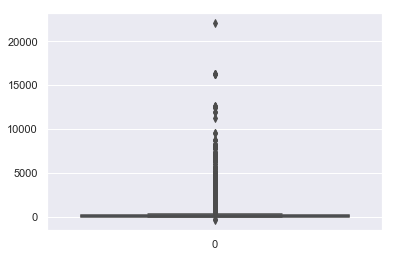

In [50]:
sns.boxplot(data=customers.first_order_total_revenue)

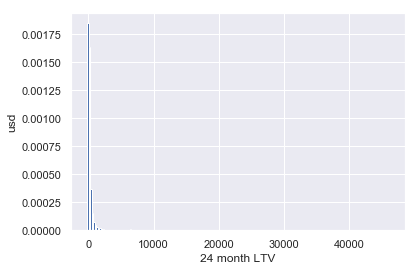

<Figure size 5760x2880 with 0 Axes>

In [51]:
_ = plt.hist(customers.revenue_24m, bins=200, normed= True)
_ = plt.xlabel('24 month LTV')
_ = plt.ylabel('usd')
_ = plt.figure(figsize=(80,40))

descriptive analysis
histogram
scatterplot
distribution check
correlation check

rf computation

In [52]:
customers.describe()

,customer_id,fo_company_name_flag,fo_discount_flag,fo_upload_flag,sum_lifetime_net_sales,first_order_revenue,qty_first_order,first_order_total_revenue,revenue_24m
count,1.718050e+05,171805.000000,171805.000000,171805.000000,171805.000000,171803.000000,171803.000000,171805.000000,171805.000000
mean,4.023345e+06,0.033637,0.117348,0.999272,378.407209,93.344640,627.177378,189.622666,280.220821
std,1.070881e+05,0.180293,0.321836,0.026964,1415.813592,175.938984,2531.439508,402.243536,819.016245
min,3.822657e+06,0.000000,0.000000,0.000000,-382.110000,-382.110000,0.000000,-382.110000,-382.110000
25%,3.932138e+06,0.000000,0.000000,1.000000,54.860000,35.320000,25.000000,47.460000,51.940000
50%,4.023672e+06,0.000000,0.000000,1.000000,115.080000,54.010000,150.000000,86.000000,103.380000
75%,4.116620e+06,0.000000,0.000000,1.000000,290.620000,98.730000,500.000000,184.060000,239.330000
max,4.205449e+06,1.000000,1.000000,1.000000,85454.350000,22096.750000,550000.000000,22096.750000,46285.480000


In [53]:
customers.head()

,customer_id,state_or_province,fo_order_channel,fo_origin,fo_f_item,fo_f_category,fo_f_product,fo_qm_channel,fo_qm_publisher,fo_qm_device,fo_company_name_flag,fo_discount_flag,fo_upload_flag,fedex_fo_address_flag,customer_first_order_own_shipping_flag,sum_lifetime_net_sales,first_order_revenue,address_flag,Printing_facility,qty_first_order,first_order_total_revenue,revenue_24m
0,3822657,CA,Online,NaN,Car Magnets,Magnets,Marketing Materials,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Residential,n,34.42,34.42,Residential,Van Nuys,2.0,34.42,34.42
1,3822663,CA,Online,Online-Desktop,Large Format Posters,Posters,Signage and Display,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Business,n,26.18,26.18,Business,Van Nuys,1.0,26.18,26.18
2,3822667,NaN,Online,Online-Desktop,Stickers,Stickers,Stickers and Labels,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Residential,n,34.14,34.14,Residential,Van Nuys,100.0,34.14,34.14
3,3822673,TX,Online,Online-Desktop,Rack Cards,Rack Cards,Marketing Materials,Direct,NaN,NaN,1.0,0.0,1.0,Business,n,144.85,47.96,Business,Arlington,100.0,47.96,144.85
4,3822677,NaN,Online,Online-Desktop,Labels,Labels,Stickers and Labels,Direct,NaN,NaN,0.0,0.0,1.0,Residential,n,48.87,48.87,Residential,Arlington,75.0,48.87,48.87


In [58]:
import plotly.express as px
data = customers

# data_canada = data[data.country == 'Canada']
fig = px.bar(data, x='fo_order_channel', y='revenue_24m',
             hover_data=['first_order_total_revenue', 'qty_first_order'], color='lifeExp',
#              labels={'pop':'population of Canada'}, 
             height=400)
fig.show()

ImportError: cannot import name 'qualitative'

In [56]:
! pip install plotly==4.4.1

     |████████████████████████████████| 7.3MB 2.2MB/s 
  Found existing installation: plotly 3.4.0
    Uninstalling plotly-3.4.0:
      Successfully uninstalled plotly-3.4.0
You should consider upgrading via the 'pip install --upgrade pip' command.


In [61]:
!pip install --upgrade plotly 
import plotly.express as px

Requirement already up-to-date: plotly in /Users/lylay/anaconda3/lib/python3.6/site-packages (4.4.1)
You should consider upgrading via the 'pip install --upgrade pip' command.


ImportError: cannot import name 'qualitative'

<BarContainer object of 171805 artists>

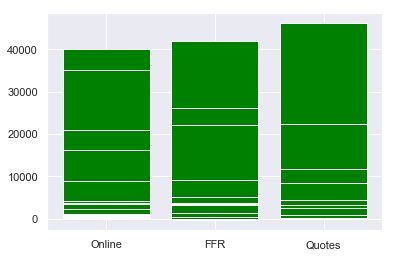

In [63]:
plt.bar(customers.fo_order_channel, customers.revenue_24m, color='green')

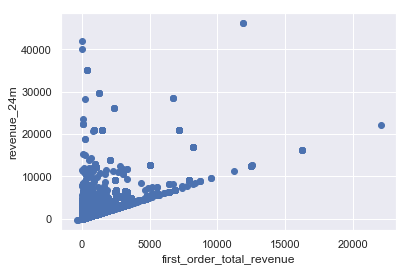

In [67]:
plt.scatter(customers[['first_order_total_revenue']], customers[['revenue_24m']], marker='o')
plt.xlabel('first_order_total_revenue')
plt.ylabel('revenue_24m')
plt.show()

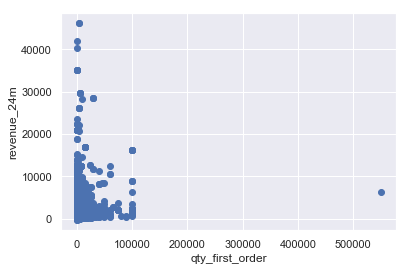

In [66]:
plt.scatter(customers[['qty_first_order']], customers[['revenue_24m']], marker='o')
plt.xlabel('qty_first_order')
plt.ylabel('revenue_24m')
plt.show()

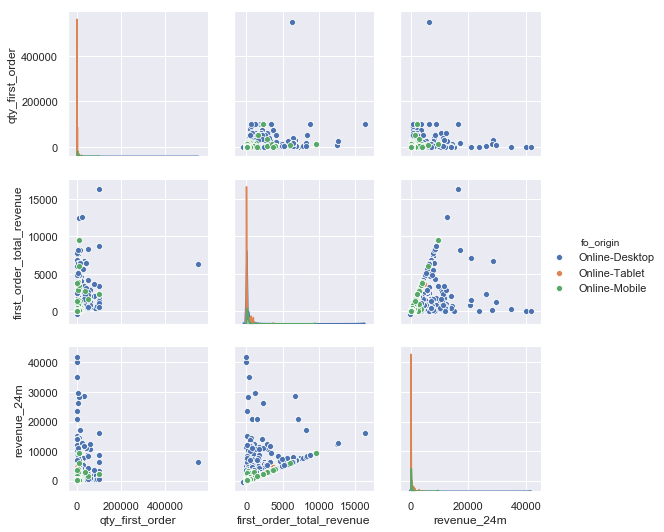

In [70]:
# create scatterplot matrix
sns.pairplot(customers[['qty_first_order','first_order_total_revenue','revenue_24m','fo_origin']], 
                   hue='fo_origin')


In [ ]:
sns.pairplot(customers[['qty_first_order','first_order_total_revenue','revenue_24m','fo_qm_channel']], 
                   hue='fo_qm_channel')

In [ ]:
sns.pairplot(customers[['qty_first_order','first_order_total_revenue','revenue_24m','fo_qm_device']], 
                   hue='fo_qm_device')

In [ ]:
sns.swarmplot(x='fo_order_channel', y='revenue_24m',  data=customers)


### 5. Is there a hypothesis you’d like to investigate further? 
- business type customers have higher 24m LTV
- should we open more pickup location? - if the pickup customers has higher 24 month LTV

### 6. What other questions do the insights lead you to ask? 
- which channel/device/publisher acquires higher valuable customers?
- Does qty_first_order/fo_f_category affect 24 month LTV?
- Geo factors( to customers 24 month LTV VS first order value

USE Visualization

### Capstone Project 1: Statistical Data Analysis
Think of the following questions and apply them to your dataset:

1. Are there variables that are particularly significant in terms of explaining the answer to your project question?
2. Are there significant differences between subgroups in your data that may be relevant to your project aim?
3. Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?
4. What are the most appropriate tests to use to analyze these relationships?

Submission: Write a 1-2 page report on the steps and findings of your inferential statistical analysis. Upload this report to your GitHub and submit a link. Eventually, this report will get incorporated into your milestone report.

## Capstone Project 1: Milestone Report
Think of a milestone report as an interim report that you may be asked to share with your client to keep them updated on your findings. It’s also an opportunity for you to take stock of how far you’ve come, what you’ve found, and practice your data storytelling skills. Your report is similar to an early draft of the final capstone project 1 report.

The milestone report compiles all the reports that you’ve been writing throughout the course. Hopefully, you’ve been keeping your findings organized and regularly documenting your findings. You should not need to do any new data analysis for this report.

Steps:

1. Write a capstone project 1 milestone report (Google Doc, 5-6 pages) and include the following:
- Problem statement: Why it’s a useful question to answer and for whom (source this from your proposal)
- Description of the dataset, how you obtained, cleaned, and wrangled it (source this from your data wrangling report)
- Initial findings from exploratory analysis (source this from your data story and inferential statistics reports)
a. Summary of your findings
b. Visuals and statistics to support those findings
2. Update your presentation slides.
3. Update your GitHub repository with the capstone project 1 code, milestone report, document, and slides.
4. Use the link below to share your report with your mentor for feedback, and update as needed.
5. Convert your report to .pdf and add it to your repository. Share it with your peer community.